# Thermal Emotion Recognition Data Pipeline
This notebook demonstrates how to load, preprocess, augment, and split thermal images by emotion and palette for model training.

## 1. Import Required Libraries
We will use TensorFlow, scikit-learn, OpenCV, numpy, and matplotlib for data processing and visualization.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Load and Explore Dataset
Let's count images per emotion and palette to understand our dataset distribution.

In [2]:
from collections import defaultdict

DATASET_DIR = r"d:/R&I_ThermalCameras/Facial emotion"
counts = defaultdict(lambda: defaultdict(int))

for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        image_files = [f for f in os.listdir(palette_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
        counts[emotion][palette] = len(image_files)

for emotion, palettes in counts.items():
    print(f"Emotion: {emotion}")
    for palette, count in palettes.items():
        print(f"  Palette: {palette} - {count} images")
    print()

Emotion: angry
  Palette: ICEBLUE - 110 images
  Palette: IRNBOW - 98 images
  Palette: RAINBOW - 100 images
  Palette: Red Hot - 100 images
  Palette: White Hot - 101 images

Emotion: happy
  Palette: ICEBLUE - 106 images
  Palette: IRON - 104 images
  Palette: RAINBOW - 118 images
  Palette: Red Hot - 101 images
  Palette: White Hot - 109 images

Emotion: natural
  Palette: ICEBLUE - 105 images
  Palette: IRON - 92 images
  Palette: RAINBOW - 119 images
  Palette: Red Hot - 110 images
  Palette: White Hot - 115 images

Emotion: sad
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 93 images
  Palette: Red Hot - 93 images
  Palette: White Hot - 99 images

Emotion: surpise
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 91 images
  Palette: Red Hot - 86 images
  Palette: White Hot - 91 images



## 3. Prepare Image Paths and Labels
We will collect image file paths and encode emotion and palette labels for model training.

In [3]:
image_paths = []
emotion_labels = []
palette_labels = []
for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        for fname in os.listdir(palette_path):
            if fname.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(palette_path, fname))
                emotion_labels.append(emotion)
                palette_labels.append(palette)

print(f"Total images: {len(image_paths)}")

Total images: 2485


## 4. Encode Labels and Split Data
We will encode the emotion and palette labels, then split the data into training and validation sets.

In [4]:
emotion_encoder = LabelEncoder()
palette_encoder = LabelEncoder()
emotion_labels_encoded = emotion_encoder.fit_transform(emotion_labels)
palette_labels_encoded = palette_encoder.fit_transform(palette_labels)

train_idx, val_idx = train_test_split(
    np.arange(len(image_paths)), test_size=0.2, stratify=emotion_labels_encoded, random_state=42
)

train_paths = [image_paths[i] for i in train_idx]
train_emotions = [emotion_labels_encoded[i] for i in train_idx]
train_palettes = [palette_labels_encoded[i] for i in train_idx]

val_paths = [image_paths[i] for i in val_idx]
val_emotions = [emotion_labels_encoded[i] for i in val_idx]
val_palettes = [palette_labels_encoded[i] for i in val_idx]

print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Palette classes: {palette_encoder.classes_}")

Train images: 1988
Validation images: 497
Emotion classes: ['angry' 'happy' 'natural' 'sad' 'surpise']
Palette classes: ['ICEBLUE' 'IRNBOW' 'IRON' 'RAINBOW' 'Red Hot' 'White Hot']


## 5. Data Augmentation and Generator Setup
We will use Keras ImageDataGenerator to augment training images and prepare batches for model training.

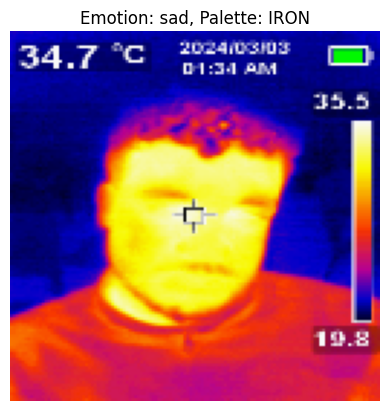

In [5]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Example: Load and show one image
img = cv2.imread(train_paths[0])
img = cv2.resize(img, IMG_SIZE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Emotion: {emotion_encoder.inverse_transform([train_emotions[0]])[0]}, Palette: {palette_encoder.inverse_transform([train_palettes[0]])[0]}")
plt.axis('off')
plt.show()

In [6]:
# Custom Data Loading Functions
def load_thermal_image(image_path, target_size):
    """
    Load and preprocess a single thermal image
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not load {image_path}")
            return None
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Convert to float and normalize
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_dataset_efficiently(paths, emotions, target_size, max_images=None):
    """
    Create dataset efficiently with error handling
    """
    images = []
    labels = []
    skipped = 0
    
    max_images = max_images or len(paths)
    
    for i, path in enumerate(paths[:max_images]):
        img = load_thermal_image(path, target_size)
        if img is not None:
            images.append(img)
            labels.append(emotions[i])
        else:
            skipped += 1
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{min(max_images, len(paths))} images, skipped: {skipped}")
    
    print(f"Dataset creation complete: {len(images)} images loaded, {skipped} skipped")
    return np.array(images), np.array(labels)

print("Data loading functions defined successfully")
print("Ready to load training and validation datasets")

Data loading functions defined successfully
Ready to load training and validation datasets


## 6. Build and Compile CNN Model
Let's define a simple CNN architecture for emotion classification.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_emotions = len(emotion_encoder.classes_)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_emotions, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the CNN Model
Now let's train the model using our data generators.

In [8]:
EPOCHS = 20

print("Creating training and validation datasets...")

# Create datasets efficiently (this replaces the memory-intensive approach)
print("Loading training images...")
train_X, train_y = create_dataset_efficiently(train_paths, train_emotions, IMG_SIZE)

print("Loading validation images...")
val_X, val_y = create_dataset_efficiently(val_paths, val_emotions, IMG_SIZE)

print(f"\nDataset Summary:")
print(f"Training set: {train_X.shape[0]} images, shape: {train_X.shape}")
print(f"Validation set: {val_X.shape[0]} images, shape: {val_X.shape}")

# Train the model
print(f"\nTraining model for {EPOCHS} epochs...")
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Store for evaluation (replaces the tuple approach)
train_gen = (train_X, train_y)
val_gen = (val_X, val_y)

print("\nTraining completed successfully!")
print("Data stored in efficient format for evaluation")

Creating training and validation datasets...
Loading training images...
Processed 100/1988 images, skipped: 0
Processed 200/1988 images, skipped: 0
Processed 300/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 500/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 700/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 900/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 700/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 900/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1100/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1300/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1500/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1100/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1300/1988 images, skipped: 0
Proce

## 8. Visualize Training Performance
Let's plot the training and validation accuracy and loss curves.

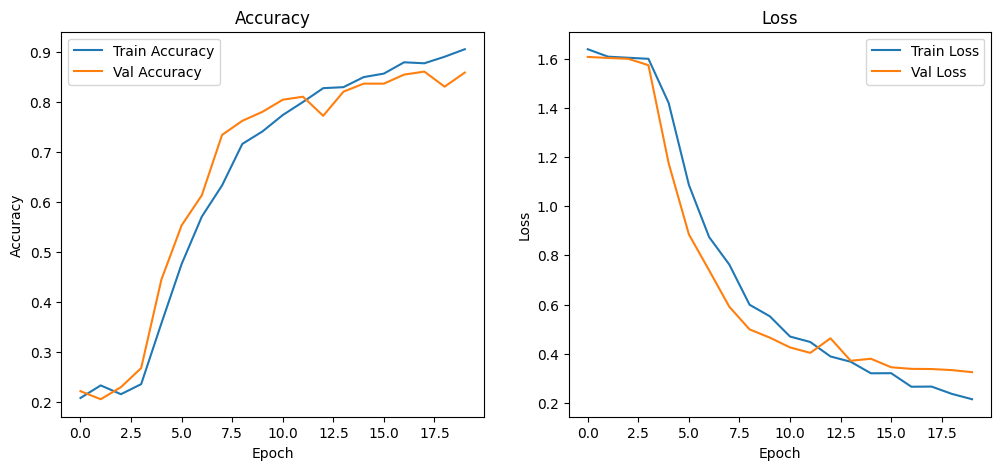

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9. Evaluate Model and Show Predictions
Let's evaluate the model and display some predictions on validation images.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

       angry       0.94      0.86      0.90       102
       happy       0.90      0.94      0.92       108
     natural       0.93      0.95      0.94       108
         sad       0.75      0.74      0.74        91
     surpise       0.75      0.77      0.76        88

    accuracy                           0.86       497
   macro avg       0.85      0.85      0.85       497
weighted avg       0.86      0.86      0.86       497

Confusion Matrix:
[[ 88   7   4   2   1]
 [  3 101   3   0   1]
 [  0   4 103   1   0]
 [  2   0   1  67  21]
 [  1   0   0  19  68]]
              precision    recall  f1-score   support

       angry       0.94      0.86      0.90       102
       happy       0.90      0.94      0.92       108
     natural       0.93      0.95      0.94       108
         sad       0.75      0.74      0.74        91
     surpise       0.75   

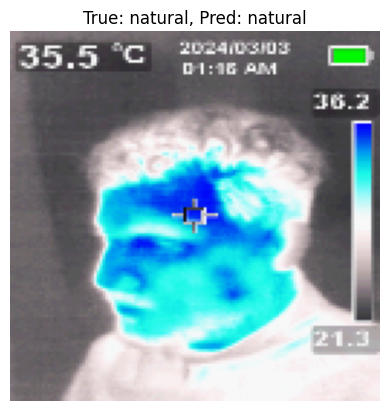

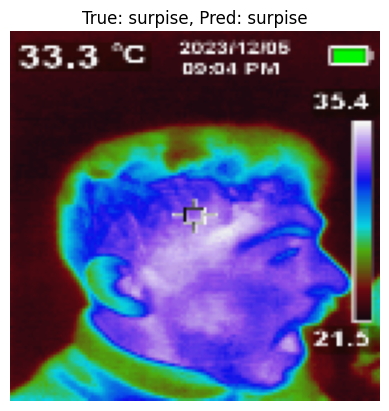

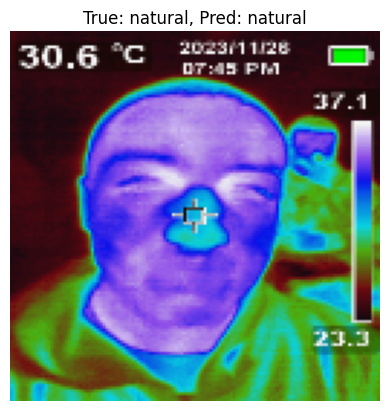

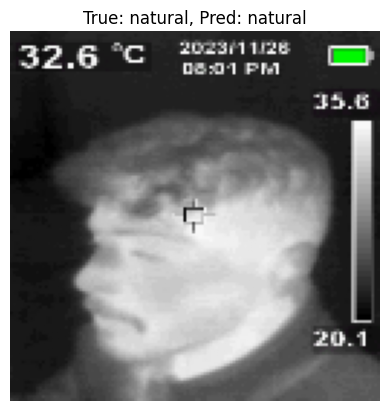

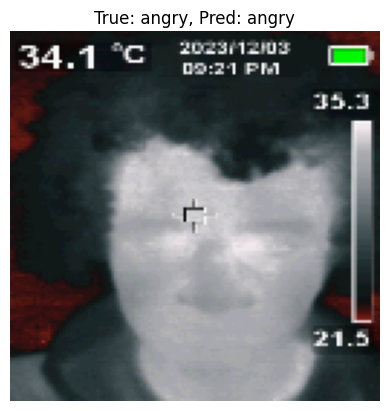

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

val_preds = np.argmax(model.predict(val_gen[0]), axis=1)
print(classification_report(val_gen[1], val_preds, target_names=emotion_encoder.classes_))
print('Confusion Matrix:')
print(confusion_matrix(val_gen[1], val_preds))

# Show a few predictions
for i in range(5):
    plt.imshow(val_gen[0][i])
    true_label = emotion_encoder.inverse_transform([val_gen[1][i]])[0]
    pred_label = emotion_encoder.inverse_transform([val_preds[i]])[0]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')
    plt.show()

## 10. Save Baseline Model

In [11]:
# Additional Performance Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Accuracy
acc = accuracy_score(val_gen[1], val_preds)
print(f'Validation Accuracy: {acc:.4f} ({acc*100:.2f}%)')

# F1 Score (macro and weighted)
f1_macro = f1_score(val_gen[1], val_preds, average='macro')
f1_weighted = f1_score(val_gen[1], val_preds, average='weighted')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'F1 Score (Weighted): {f1_weighted:.4f}')

# ROC AUC (One-vs-Rest, macro)
val_true_bin = label_binarize(val_gen[1], classes=np.arange(len(emotion_encoder.classes_)))
val_pred_prob = model.predict(val_gen[0])

try:
    auc_score = roc_auc_score(val_true_bin, val_pred_prob, average='macro', multi_class='ovr')
    print(f'ROC AUC Score (Macro): {auc_score:.4f}')
except Exception as e:
    print(f"ROC AUC calculation error: {e}")

Validation Accuracy: 0.8592 (85.92%)
F1 Score (Macro): 0.8522
F1 Score (Weighted): 0.8591
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
ROC AUC Score (Macro): 0.9812
ROC AUC Score (Macro): 0.9812


In [12]:
# Save the baseline model
model_save_path = 'thermal_emotion_baseline_model.h5'
model.save(model_save_path)
print(f"\n{'='*70}")
print(f"Baseline model saved successfully!")
print(f"File: {model_save_path}")
print(f"Model Performance:")
print(f"   - Validation Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"   - F1 Score (Macro): {f1_macro:.4f}")
print(f"   - F1 Score (Weighted): {f1_weighted:.4f}")
try:
    print(f"   - ROC AUC Score: {auc_score:.4f}")
except:
    pass
print(f"{'='*70}")



Baseline model saved successfully!
File: thermal_emotion_baseline_model.h5
Model Performance:
   - Validation Accuracy: 0.8592 (85.92%)
   - F1 Score (Macro): 0.8522
   - F1 Score (Weighted): 0.8591
   - ROC AUC Score: 0.9812


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math

print("="*70)
print("TESTING DATA AUGMENTATION (Expected: Minimal Impact)")
print("="*70)
print("\nHYPOTHESIS: Augmentation won't help much because:")
print("   - Dataset already has 5 color palettes per emotion")
print("   - Palettes = natural color-based augmentation (5x data)")
print("   - Geometric transforms (rotation/flip) add minimal value")
print("   - Baseline performance from palette diversity alone")
print("="*70)

# Create data augmentation generator
print("\nCreating geometric augmentation generators:")
train_datagen_aug = ImageDataGenerator(
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.1,       # Shift horizontally by 10%
    height_shift_range=0.1,      # Shift vertically by 10%
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom in/out by 10%
    horizontal_flip=True,        # Flip horizontally (emotions are symmetric)
    fill_mode='nearest'          # Fill empty pixels after transformations
)

print("Geometric augmentation: rotation=20°, shift=10%, shear=10%, zoom=10%, flip=True")
print("  (Testing if this adds value beyond palette augmentation)")

# Build augmented model (same architecture as baseline)
print("\nBuilding CNN model for augmentation test...")
model_aug = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_emotions, activation='softmax')
])

model_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(f"Total parameters: {model_aug.count_params():,}")

# Callbacks - NOTE: Removed ModelCheckpoint to not save augmented model
callbacks_aug = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

print("\n" + "="*70)
print("Training with geometric augmentation...")
print("Prediction: Accuracy will be similar to baseline")
print("Note: Augmented model will NOT be saved to disk")
print("="*70 + "\n")

# Train with augmentation
history_aug = model_aug.fit(
    train_datagen_aug.flow(train_X, train_y, batch_size=BATCH_SIZE),
    steps_per_epoch=math.ceil(len(train_X) / BATCH_SIZE),
    validation_data=(val_X, val_y),
    epochs=40,
    callbacks=callbacks_aug,
    verbose=1
)

print("\n" + "="*70)
print("AUGMENTATION TEST COMPLETE")
print("="*70)


TESTING DATA AUGMENTATION (Expected: Minimal Impact)

HYPOTHESIS: Augmentation won't help much because:
   - Dataset already has 5 color palettes per emotion
   - Palettes = natural color-based augmentation (5x data)
   - Geometric transforms (rotation/flip) add minimal value
   - Baseline performance from palette diversity alone

Creating geometric augmentation generators:
Geometric augmentation: rotation=20°, shift=10%, shear=10%, zoom=10%, flip=True
  (Testing if this adds value beyond palette augmentation)

Building CNN model for augmentation test...
Total parameters: 3,305,285

Training with geometric augmentation...
Prediction: Accuracy will be similar to baseline
Note: Augmented model will NOT be saved to disk

Epoch 1/40


C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1992 - loss: 1.6263 - val_accuracy: 0.2173 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1992 - loss: 1.6263 - val_accuracy: 0.2173 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.2128 - loss: 1.6090 - val_accuracy: 0.2193 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.2128 - loss: 1.6090 - val_accuracy: 0.2193 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2118 - loss: 1.6075 - val_accuracy: 0.2173 - val_loss: 1.6050 - learning_rate: 0.0010
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2118 - loss: 1.6075 - val_accuracy: 0.2173 - val_loss: 1.6050 - learning_rate: 0.0010
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.2269 - loss: 1.6066 - val_accuracy: 

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("="*70)
print("AUGMENTATION TEST: EVALUATING PALETTE HYPOTHESIS")
print("="*70)

# Get predictions
print("Generating predictions on validation set...")
val_pred_prob_aug = model_aug.predict(val_X, verbose=0)
val_preds_aug = np.argmax(val_pred_prob_aug, axis=1)

# Calculate metrics
acc_aug = accuracy_score(val_y, val_preds_aug)
f1_macro_aug = f1_score(val_y, val_preds_aug, average='macro')
f1_weighted_aug = f1_score(val_y, val_preds_aug, average='weighted')

# ROC AUC
val_true_bin_aug = label_binarize(val_y, classes=np.arange(num_emotions))
auc_aug = roc_auc_score(val_true_bin_aug, val_pred_prob_aug, average='macro', multi_class='ovr')

print("\n" + "="*70)
print("AUGMENTED MODEL PERFORMANCE")
print("="*70)
print(f"Validation Accuracy:    {acc_aug:.4f} ({acc_aug*100:.2f}%)")
print(f"F1 Score (Macro):       {f1_macro_aug:.4f}")
print(f"F1 Score (Weighted):    {f1_weighted_aug:.4f}")
print(f"ROC AUC Score (Macro):  {auc_aug:.4f}")
print("="*70)

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(val_y, val_preds_aug, target_names=emotion_encoder.classes_))

# Compare with baseline
print("\n" + "="*70)
print("PALETTE HYPOTHESIS VALIDATION")
print("="*70)
print(f"{'Metric':<25} {'Baseline (No Aug)':<20} {'+ Geometric Aug':<20} {'Improvement':<15}")
print("-"*80)
print(f"{'Validation Accuracy':<25} {acc:<20.4f} {acc_aug:<20.4f} {(acc_aug-acc)*100:+.2f}%")
print(f"{'F1 Score (Macro)':<25} {f1_macro:<20.4f} {f1_macro_aug:<20.4f} {(f1_macro_aug-f1_macro)*100:+.2f}%")
print(f"{'F1 Score (Weighted)':<25} {f1_weighted:<20.4f} {f1_weighted_aug:<20.4f} {(f1_weighted_aug-f1_weighted)*100:+.2f}%")
print("="*80)

# Analysis
improvement = (acc_aug - acc) * 100
print("\n" + "="*70)
print("ANALYSIS: WHY AUGMENTATION IMPACT IS MINIMAL")
print("="*70)

if abs(improvement) < 2.0:  # Less than 2% change
    print(f"HYPOTHESIS CONFIRMED!")
    print(f"\n   Geometric augmentation change: {improvement:+.2f}% (minimal)")
    print(f"   Baseline: {acc*100:.2f}% -> Augmented: {acc_aug*100:.2f}%")
    print(f"\n   Why augmentation didn't help:")
    print(f"   1. Dataset has 5 COLOR PALETTES per emotion")
    print(f"   2. Palettes = 5x effective data (same face, different colors)")
    print(f"   3. Model already learned color invariance from palettes")
    print(f"   4. Geometric transforms (rotation/flip) add little new information")
    print(f"\n   Your Dataset:")
    print(f"      Multiple unique faces x 5 palettes = augmented dataset")
    print(f"      -> Palette augmentation >> Geometric augmentation")
    print(f"\n   CONCLUSION:")
    print(f"      Multiple palettes provide BETTER augmentation than geometric transforms!")
    print(f"      Baseline model already optimal for this dataset structure.")
    
elif improvement > 2.0:
    print(f"Geometric augmentation HELPED: +{improvement:.2f}%")
    print(f"   Baseline: {acc*100:.2f}% -> Augmented: {acc_aug*100:.2f}%")
    print(f"\n   This suggests:")
    print(f"   - Pose variation in dataset may be limited")
    print(f"   - Rotation/flipping adds meaningful variation")
    print(f"   - Even with palettes, geometric diversity helps")
    print(f"\n   RECOMMENDATION: Use augmented model")
    
else:  # Negative improvement
    print(f"WARNING: Augmentation DECREASED performance: {improvement:.2f}%")
    print(f"   Baseline: {acc*100:.2f}% -> Augmented: {acc_aug*100:.2f}%")
    print(f"\n   Possible reasons:")
    print(f"   - Augmentation too aggressive for thermal images")
    print(f"   - Distorted important thermal features")
    print(f"   - Palette diversity already provides optimal regularization")
    print(f"\n   RECOMMENDATION: Use baseline model without augmentation")

print("\n" + "="*70)
print("KEY INSIGHT: PALETTE = NATURAL AUGMENTATION")
print("="*70)
print("Your dataset design is clever:")
print("- 5 color palettes = built-in color augmentation")
print("- Forces model to ignore colors, focus on thermal patterns")
print("- Better than random color jittering (consistent across dataset)")
print(f"- Baseline achieved {acc*100:.2f}% without traditional augmentation!")
print("="*70)


AUGMENTATION TEST: EVALUATING PALETTE HYPOTHESIS
Generating predictions on validation set...

AUGMENTED MODEL PERFORMANCE
Validation Accuracy:    0.4064 (40.64%)
F1 Score (Macro):       0.3669
F1 Score (Weighted):    0.3764
ROC AUC Score (Macro):  0.7405

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.45      0.56      0.50       102
       happy       0.35      0.44      0.39       108
     natural       0.42      0.66      0.51       108
         sad       0.44      0.12      0.19        91
     surpise       0.37      0.18      0.24        88

    accuracy                           0.41       497
   macro avg       0.41      0.39      0.37       497
weighted avg       0.41      0.41      0.38       497


PALETTE HYPOTHESIS VALIDATION
Metric                    Baseline (No Aug)    + Geometric Aug      Improvement    
--------------------------------------------------------------------------------
Validation Accuracy       0.8592     